2025-02-01 13:38:43,522 - INFO - Loading Images..
2025-02-01 13:38:43,647 - INFO - Done Loading Images..
2025-02-01 13:38:43,647 - INFO - Applying Flat Field Correction..


Project Image Path: E:/DataBetaTest/07082024/24-MCH-24A/mentah/24-MCH-24A_Manus_R 24-MCH-24A 80kV50mA0,50s -8_7_2024-9.33 AM [Administrator].mdn
Gain Image Path: E:/Project/imager-pipeline/imager-pipeline/datacitra/Gain/Bed/80_50_0,50.mdn
Dark Image Path: E:/Project/imager-pipeline/imager-pipeline/datacitra/Dark/Bed/dark.mdn


2025-02-01 13:38:44,707 - INFO - Done Applying Flat Field Correction..
2025-02-01 13:38:44,708 - INFO - Applying Spatial Calibration Correction..
2025-02-01 13:38:44,838 - INFO - Done Applying Spatial Calibration Correction..


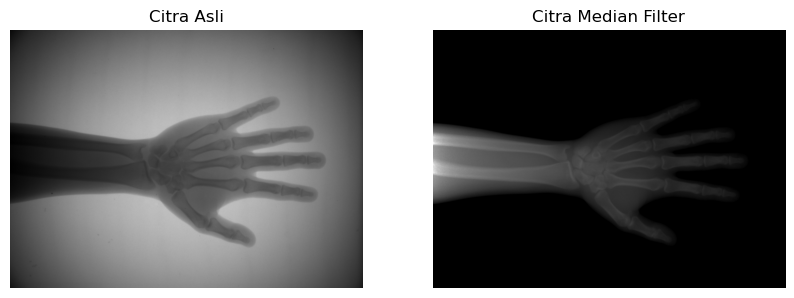

2025-02-01 13:38:47,546 - INFO - Start Image Decompositiion (BEMD)..


2025-02-01 13:38:49,677 - INFO - Stopping criteria met: fewer than 10 extrema points


2025-02-01 13:38:49,677 - INFO - FABEMD decomposition completed
2025-02-01 13:38:49,678 - INFO - Finish Image Decompositiion (BEMD)..
2025-02-01 13:38:50,939 - INFO - Finding Best Processed Image with Various Parameters..


Total parameter combinations: 18


C:\Users\andrelouk\AppData\Local\Temp\ipykernel_8972\1985090914.py:32: RuntimeWarning: invalid value encountered in power
  img_gamma_corrected = np.power(img_normalized, gamma)
C:\Users\andrelouk\AppData\Local\Temp\ipykernel_8972\1985090914.py:35: RuntimeWarning: invalid value encountered in cast
  img_gamma_corrected = np.uint16(img_gamma_corrected * 65535)


params (20, 2.0, 0.3, 0.8, 3.0, (8, 8)), score 108.20029786722603, cii 1.0, ent 3.258732318878174, eme 103.94156554834785
params (30, 1.5, 0.3, 0.8, 3.0, (8, 8)), score 108.21625583864156, cii 1.0, ent 3.2710063457489014, eme 103.94524949289266
params (20, 2.0, 0.5, 0.8, 3.0, (8, 8)), score 108.19599894013281, cii 1.0, ent 3.256336212158203, eme 103.9396627279746
params (20, 1.5, 0.3, 0.8, 3.0, (8, 8)), score 108.19773009788861, cii 1.0, ent 3.2574925422668457, eme 103.94023755562176
params (20, 2.5, 0.3, 0.8, 3.0, (8, 8)), score 108.20263190149265, cii 1.0, ent 3.2596242427825928, eme 103.94300765871006
params (20, 1.5, 0.5, 0.8, 3.0, (8, 8)), score 108.19275467507617, cii 1.0, ent 3.2549257278442383, eme 103.93782894723194
params (20, 2.5, 0.5, 0.8, 3.0, (8, 8)), score 108.19773009788861, cii 1.0, ent 3.2574925422668457, eme 103.94023755562176
params (30, 1.5, 0.5, 0.8, 3.0, (8, 8)), score 108.20915397292725, cii 1.0, ent 3.26400089263916, eme 103.9451530802881
params (30, 2.0, 0.3, 

2025-02-01 13:39:20,309 - INFO - best_image data type : <class 'numpy.ndarray'>


params (40, 2.5, 0.3, 0.8, 3.0, (8, 8)), score 109.6165746847679, cii 1.0, ent 3.288417339324951, eme 105.32815734544295
params (40, 2.5, 0.5, 0.8, 3.0, (8, 8)), score 108.23507306047256, cii 1.0, ent 3.282588481903076, eme 103.95248457856948


2025-02-01 13:39:20,353 - INFO - Best Processed Image Acquired and saved..


(40, 2.5, 0.3, 0.8, 3.0, (8, 8))


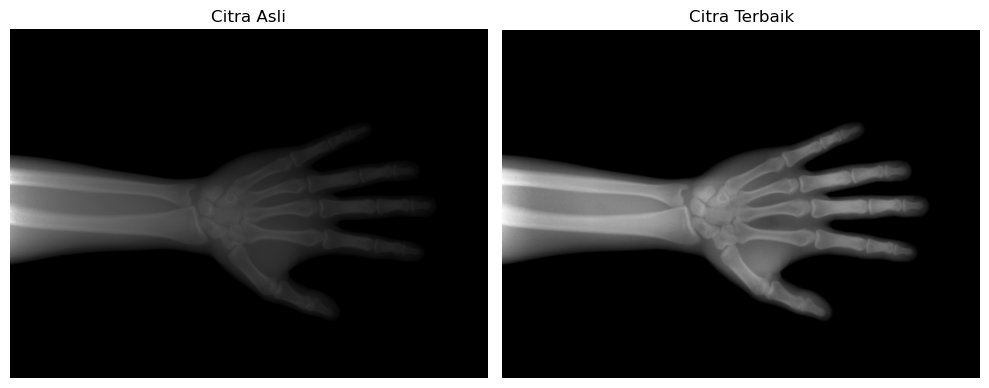

2025-02-01 13:39:22,916 - INFO - Cleaning Up Memory..
2025-02-01 13:39:22,999 - INFO - Memory Cleaned..


In [8]:
import os
import cv2
import cupy as cp
import numpy as np
import itertools
import matplotlib.pyplot as plt
import logging
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import json

import ffc
import calibrate_image
import bemd

import image_resizer as ir
import homomorphic_filter as hf
import nonlinear_filtering as nf
import metrics

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

def gamma_correction(image, gamma=0.8):
    # Normalize the image to the range [0, 1]
    img_normalized = image / 65535.0
    
    # Apply gamma correction
    img_gamma_corrected = np.power(img_normalized, gamma)
    
    # Scale back to the 16-bit range [0, 65535]
    img_gamma_corrected = np.uint16(img_gamma_corrected * 65535)
    
    return img_gamma_corrected

def apply_clahe(image, clip_limit=0.5, tile_grid_size=(8, 8)):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Apply CLAHE to the image
    return clahe.apply(image)

def process_parameters(params, reference_image, BIMFs, energies):
    d0, rh, rl, gamma, clip_limit, tile_grid_size = params
    
    # Apply homomorphic filter
    filtered_image = hf.homomorphic_filter(reference_image, d0=d0, rh=rh, rl=rl)

    # Reconstruct the image
    reconstructed_image = nf.denoise(BIMFs, energies, filtered_image, R=1, beta=0.5)

    # Apply gamma correction
    gamma_corrected_image = gamma_correction(reconstructed_image, gamma=gamma)

    # Apply CLAHE
    clahe_image = apply_clahe(gamma_corrected_image, clip_limit=clip_limit, tile_grid_size=tile_grid_size)

    # Calculate CII
    mask = np.ones_like(reference_image)
    cii = metrics.calculate_cii(clahe_image, reference_image, mask)

    # Calculate entropy
    entropy = metrics.calculate_entropy(clahe_image)

    # Calculate EME
    r, c = 4, 4
    eme = metrics.calculate_eme(clahe_image, r, c)

    evaluation_result = cii + entropy + eme

    del filtered_image, reconstructed_image, gamma_corrected_image, mask
    gc.collect()

    return evaluation_result, cii, entropy, eme, params, clahe_image


def load_config(file_path):
    with open(file_path, 'r') as file:
        config = json.load(file)
    return config

def set_env_variables(config):
    for key, value in config.items():
        os.environ[key] = value

def get_env_variable(var_name):
    return os.getenv(var_name)    

def main():
    logging.info("Loading Images..")
    datacitra_path = os.path.abspath(os.path.join(os.path.dirname("main.py"), os.pardir, 'datacitra'))
    
    config_path = "config.json"
    
    # Load the configuration from the json file
    with open(config_path, 'r') as f:
        config = json.load(f)
   
    # proj_img_path = datacitra_path + os.sep + '3_WWI_03B_Thorax_AP.tiff'
    # gain_img_path = datacitra_path + os.sep + 'Gain' + os.sep + 'Trx' + os.sep + '90_40_0,50.mdn'
    # dark_img_path = datacitra_path + os.sep + 'Dark' + os.sep + 'Trx' + os.sep + 'dark.mdn'

    # Extract the paths from the configuration
    proj_img_path = config.get('proj_img_path')
    gain_img_path = config.get('gain_img_path')
    dark_img_path = config.get('dark_img_path')

    print("Project Image Path:", proj_img_path)
    print("Gain Image Path:", gain_img_path)
    print("Dark Image Path:", dark_img_path)

    proj_img = cv2.imread(proj_img_path, -1)
    gain_img = cv2.imread(gain_img_path, -1)
    dark_img = cv2.imread(dark_img_path, -1)
    logging.info("Done Loading Images..")

    logging.info("Applying Flat Field Correction..")
    imgFFC = ffc.ffcimg(proj_img, gain_img, dark_img)
    logging.info("Done Applying Flat Field Correction..")

    logging.info("Applying Spatial Calibration Correction..")
    calib_spat_param_path = os.path.abspath(os.path.join(os.path.dirname("main.py"), os.pardir, 'datacitra')) + os.sep + 'Kalibrasi' + os.sep + 'bed_44_35.npz'
    img_spatially_calibrated = calibrate_image.calibrate_spasial(calib_spat_param_path,imgFFC)
    logging.info("Done Applying Spatial Calibration Correction..")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Citra Asli')
    plt.imshow(proj_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Citra Median Filter')
    plt.imshow(img_spatially_calibrated, cmap='gray')
    plt.axis('off')
    plt.show()


    logging.info("Start Image Decompositiion (BEMD)..")
    # Perform FABEMD decomposition
    BIMFs = bemd.fabemd(cp.asarray(img_spatially_calibrated), max_iterations=1, threshold=1, initial_window_size=32, local_extrema_count=10)
    logging.info("Finish Image Decompositiion (BEMD)..")

    # Calculating Energies of BIMFs
    energies = []
    for bimf in BIMFs:
        energy = np.sum(np.square(np.array(bimf.get())))
        energies.append(energy)
    
    logging.info("Finding Best Processed Image with Various Parameters..")
    # Find Best Processed Image
    # Define parameter ranges
    d0_values = [20, 30, 40]
    rh_values = [1.5, 2.0, 2.5]
    rl_values = [0.3, 0.5]
    gamma_values = [0.8]
    clip_limit_values = [3.0]
    tile_grid_size_values = [(8, 8)]

    # Generate parameter combinations
    parameter_combinations = list(
        itertools.product(
            d0_values,
            rh_values,
            rl_values,
            gamma_values,
            clip_limit_values,
            tile_grid_size_values,
        )
    )

    print("Total parameter combinations:", len(parameter_combinations))

    # Initialize variables to store evaluation results
    best_cii = 0.0
    best_entropy = 0.0
    best_emr = 0.0
    best_parameters = None
    best_image = None

    # Use ThreadPoolExecutor to process parameter combinations concurrently
    with ThreadPoolExecutor(8) as executor:
        futures = [executor.submit(process_parameters, params, img_spatially_calibrated, BIMFs, energies ) for params in parameter_combinations]

        for future in as_completed(futures):
            evaluation_result, cii, entropy, eme, params, clahe_image = future.result()
            print(f"params {params}, score {evaluation_result}, cii {cii}, ent {entropy}, eme {eme}")
            if evaluation_result > best_cii + best_entropy + best_emr:
                best_cii = cii
                best_entropy = entropy
                best_emr = eme
                best_parameters = params
                best_image = clahe_image
    min_val = cp.min(best_image)
    max_val = cp.max(best_image)
    best_image = min_val + ((best_image - min_val) / (max_val - min_val) * 65535)
    best_image = ir.resize_image(best_image, 4096).get()
    logging.info(f"best_image data type : {type(best_image)}")
    # Save best image
    filename = Path(proj_img_path).stem
    filename = filename + "_processed.tiff"
    cv2.imwrite(datacitra_path+ os.sep + filename, best_image.astype(np.uint16),params=(cv2.IMWRITE_TIFF_COMPRESSION, 1))
    print(best_parameters)
    logging.info("Best Processed Image Acquired and saved..")

    # plt.figure(figsize=(10, 5))

    # plt.subplot(1, 2, 1)
    # plt.title('Citra Asli')
    # plt.imshow(proj_img, cmap='gray')
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.title('Citra Median Filter')
    # plt.imshow(img_spatially_calibrated, cmap='gray')
    # plt.axis('off')

    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 3, 1)
    # plt.imshow(img_spatially_calibrated, cmap="gray")
    # plt.title("Original Image")
    # plt.axis("off")

    # plt.subplot(1, 3, 2)
    # plt.imshow(residue, cmap="gray")
    # plt.title("Residue")
    # plt.axis("off")

    # plt.subplot(1, 3, 3)
    # plt.imshow(BIMFs[len(BIMFs)-1].get(),cmap="gray")
    # plt.title(f"BIMF {len(BIMFs)}")
    # plt.axis("off")

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Citra Asli')
    plt.imshow(img_spatially_calibrated, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Citra Terbaik')
    plt.imshow(best_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()

    plt.show()

    logging.info("Cleaning Up Memory..")
    del datacitra_path, proj_img_path, gain_img_path, dark_img_path
    del proj_img, gain_img, dark_img
    del imgFFC, calib_spat_param_path, img_spatially_calibrated
    del BIMFs, energies
    del d0_values, rh_values, rl_values, gamma_values, clip_limit_values, tile_grid_size_values
    del parameter_combinations, best_cii, best_emr, best_entropy, best_parameters, best_image
    del min_val, max_val
    cp._default_memory_pool.free_all_blocks()
    gc.collect()
    logging.info("Memory Cleaned..")
    
if __name__ == "__main__":
    main()